In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.fep_control import fep_control
from combinators.model import active
from combinators.model import compose, foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
target = fep_control.BipedalWalkerAgent(functional_dim=12, perceptual_dim=12, batch_shape=(10,), trainable=False)
proposal = fep_control.RecognitionAgent(functional_dim=12, perceptual_dim=12, action_dim=4, observation_dim=24, batch_shape=(10,),
                                        discrete_actions=False, name='BipedalWalkerAgent', trainable=True)
agent = importance.propose(target, proposal)

In [5]:
episode = active.ActiveEpisode(agent, 'BipedalWalker-v2')

In [6]:
(control, prediction, t), graph, log_weight = episode(render=True)

In [7]:
xi, trained_params, elbos = active.active_variational(episode, 100, lr=1e-3, log_estimator=True, patience=None)

06/28/2019 15:43:42 Episode length: 236
06/28/2019 15:43:43 ELBO=-8.60828750e+04 per step at epoch 1
06/28/2019 15:43:44 Episode length: 260
06/28/2019 15:43:45 ELBO=-8.54877656e+04 per step at epoch 2
06/28/2019 15:43:46 Episode length: 65
06/28/2019 15:43:46 ELBO=-9.60230391e+04 per step at epoch 3
06/28/2019 15:43:46 Episode length: 55
06/28/2019 15:43:46 ELBO=-8.45359531e+04 per step at epoch 4
06/28/2019 15:43:47 Episode length: 74
06/28/2019 15:43:47 ELBO=-8.28399062e+04 per step at epoch 5
06/28/2019 15:43:47 Episode length: 97
06/28/2019 15:43:48 ELBO=-7.55310234e+04 per step at epoch 6
06/28/2019 15:43:48 Episode length: 92
06/28/2019 15:43:49 ELBO=-1.06143117e+05 per step at epoch 7
06/28/2019 15:43:49 Episode length: 191
06/28/2019 15:43:50 ELBO=-7.82233594e+04 per step at epoch 8
06/28/2019 15:43:50 Episode length: 65
06/28/2019 15:43:51 ELBO=-1.09900070e+05 per step at epoch 9
06/28/2019 15:43:51 Episode length: 50
06/28/2019 15:43:51 ELBO=-1.02194922e+05 per step at epoch

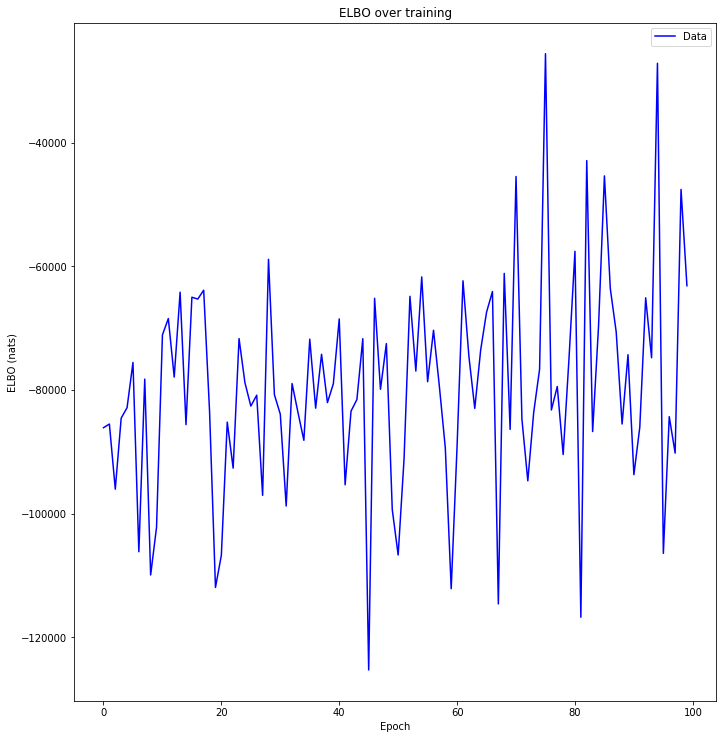

In [8]:
utils.plot_evidence_bounds(elbos[:, 0].cpu().detach().numpy())

In [ ]:
(control, prediction, t), graph, log_weight = episode(render=True)

In [10]:
control

tensor([[ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889],
        [ 0.3182, -0.4804, -0.7812,  0.0889]], grad_fn=<ExpandBackward>)

In [11]:
prediction

{'loc': tensor([[ 1.5955e-02,  6.2251e-02, -4.4485e-02,  1.2307e-04,  3.6645e-02,
           5.1393e-03,  2.7895e-02, -1.1177e-02, -1.7841e-02,  5.0468e-02,
           2.7216e-02,  2.4106e-02, -1.6215e-01, -5.5781e-02,  1.5816e-01,
          -1.8630e-01, -3.3667e-02, -8.5307e-02,  1.4422e-02, -2.1256e-01,
          -7.9198e-02, -1.3165e-01,  6.8515e-02,  9.9637e-02],
         [ 4.2067e-03,  3.2866e-02, -4.4460e-02,  2.1540e-02,  2.9879e-02,
           1.7779e-02,  4.2255e-02, -2.5539e-02, -5.2270e-02,  2.3679e-02,
           1.7962e-02,  4.2102e-02, -1.8654e-01, -6.1588e-02,  1.3696e-01,
          -2.2060e-01, -3.2557e-02, -1.2264e-01,  3.8451e-02, -2.5778e-01,
          -8.6270e-02, -1.8850e-01,  1.1020e-01,  1.1329e-01],
         [ 1.4012e-02,  4.5353e-02, -3.5089e-02, -1.3581e-02,  2.2729e-02,
          -2.8831e-03,  3.8776e-02, -2.5500e-02, -2.2743e-02,  3.3708e-02,
           6.0445e-02,  4.2846e-02, -1.4918e-01, -1.6341e-02,  1.4319e-01,
          -1.9670e-01, -2.6671e-02, -1.157

In [12]:
t

45

In [13]:
log_weight

tensor([-3904137.5000, -3904147.0000, -3904155.2500, -3904178.7500,
        -3904131.7500, -3904183.0000, -3904149.7500, -3904196.0000,
        -3904158.7500, -3904168.7500], grad_fn=<AddBackward0>)

In [14]:
torch.save(agent, 'examples/fep_control/fep_bipedal_walker_agent.dat')